In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
from herramientas import obtener_resumen_valores_unicos
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split


In [2]:
# Leer los datos
df = pd.read_csv('data/train.csv', delimiter = '|')
df1 = pd.read_csv('data/RentabilidadProduct.csv', delimiter = '|')

# Descripción de los datos

## Data Entrenamiento [train.csv]
* **fecha_compra** Dia donde un cliente hizo una compra.
* **customer_id** Codigo de cliente
* **product_id** Codigo de producto
* **type_id** Tipo de negocio (GA: Gastronomia, PA: Panificacion, BO: Bodegas)
* **business_id** Codigo tipo de producto (a que negocio pertenece el producto)
* **channel_id** Canal de venta (A: Diadia, B: Insuma, V: Tradicional)
* **cantidad_venta** Cantidad de producto comprado
* **monto_venta_transf** Monto de compra
* **peso_venta_transf** Volumen de compra

## Data Producto [RentabilidadProduct.csv]
* **product_id** Codigo de producto
* **family_id** Codigo de familia (Marca a la que pertenece)
* **negocio_id** Codigo tipo de producto (a que negocio pertenece el producto)
* **category_id** Codigo de categoria de producto
* **tier_id** Codigo de tier, indica jerarquia de un producto ( 1 = premiun, 2 = mainstream, 3=economy, 4=super economy)
* **utilidad_bruta_transf** Utilidad bruta del producto

In [3]:
obtener_resumen_valores_unicos(df)

,Columna,Tipo de Dato,Valores Únicos,Total Valores,Valores Nulos
0,fecha_compra,object,327,2167848,0
1,customer_id,int64,15312,2167848,0
2,product_id,int64,1043,2167848,0
3,type_id,object,3,2167848,0
4,business_id,int64,10,2167848,0
5,channel_id,object,3,2167848,0
6,cantidad_venta,float64,147,2167848,0
7,monto_venta_transf,float64,36737,2167848,0
8,peso_venta_transf,float64,2382,2167848,0


In [4]:
obtener_resumen_valores_unicos(df1)

,Columna,Tipo de Dato,Valores Únicos,Total Valores,Valores Nulos
0,product_id,int64,937,937,0
1,family_id,int64,231,937,0
2,negocio_id,int64,3,937,0
3,category_id,int64,50,937,0
4,tier_id,int64,4,937,0
5,utilidad_bruta_transf,float64,925,937,0


# Filtrado colaborativo basado en usuarios (User-User)

## Matriz de calificaciones

In [3]:
# Agregamos un ranking
# Agrupar por cliente y producto, y contar la frecuencia de compra
frecuencia_compra = df.groupby(['customer_id', 'product_id']).size().reset_index(name='frecuencia')

# Normalizar el ranking entre 1 y 5
frecuencia_compra['ranking'] = frecuencia_compra['frecuencia'].apply(lambda x: 5 if x > 10 else (1 if x == 1 else (x-1)//2))

# Fusionar el ranking con el DataFrame original
df_ranking = pd.merge(df, frecuencia_compra[['customer_id', 'product_id', 'ranking']], on=['customer_id', 'product_id'], how='left')

In [4]:
df_ranking.head(3)

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,ranking
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211,1
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,0


In [7]:
# Crear la matriz de calificaciones usando pivot
df_matriz = df_ranking.drop_duplicates(subset=['customer_id', 'product_id'])
matriz_calificaciones = df_matriz.pivot(index='customer_id', columns='product_id', values='ranking')

# Rellenar los valores NaN con cero si es necesario
matriz_calificaciones = matriz_calificaciones.fillna(0)

# Ahora, matriz_calificaciones es un DataFrame que contiene la matriz de calificaciones que buscas


## Cálculo de Similitud entre Usuarios

## Similitud del Coseno

In [8]:
# Calcular la similitud del coseno entre los usuarios
cosine_similarity_matrix = cosine_similarity(matriz_calificaciones)

print("Matriz de similitud del coseno:")
print(cosine_similarity_matrix)


Matriz de similitud del coseno:
[[1.         0.39337812 0.52494427 ... 0.         0.         0.        ]
 [0.39337812 1.         0.36095673 ... 0.         0.         0.        ]
 [0.52494427 0.36095673 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.28284271 0.64549722]
 [0.         0.         0.         ... 0.28284271 1.         0.18257419]
 [0.         0.         0.         ... 0.64549722 0.18257419 1.        ]]


In [9]:
def predict_ratings(similarity_matrix, matriz_calificaciones):
    # Calcular el peso promedio para cada ítem
    weighted_ratings = np.dot(similarity_matrix, matriz_calificaciones)
    
    # Suma de las similitudes para cada usuario
    sum_of_similarities = np.abs(similarity_matrix).sum(axis=1).reshape(-1, 1)
    
    # Evitar dividir por cero (en caso de que un usuario no tenga similitudes con otros)
    sum_of_similarities[sum_of_similarities == 0] = 1
    
    predicted_ratings = weighted_ratings / sum_of_similarities
    
    return predicted_ratings

# Predicciones usando las matrices de similitud
cosine_predictions = predict_ratings(cosine_similarity_matrix, matriz_calificaciones)

print("\nPredicciones con la similitud del coseno:")
print(cosine_predictions)



Predicciones con la similitud del coseno:
[[4.24301502e-02 1.92485724e-02 8.92551561e-02 ... 3.64403852e-02
  2.46329238e-02 2.17850133e-02]
 [3.43527089e-02 1.56888317e-02 8.14040976e-02 ... 2.91108399e-02
  1.99072027e-02 1.81820551e-02]
 [4.33572753e-02 2.00004228e-02 8.98556632e-02 ... 3.47040153e-02
  2.24743625e-02 2.05042736e-02]
 ...
 [4.40331248e-04 8.27398333e-04 2.52171488e-02 ... 8.58074005e-04
  2.01723949e-04 5.33130690e-04]
 [9.09630090e-05 2.56625952e-04 1.94242525e-02 ... 7.15777458e-04
  1.45213171e-04 5.86549278e-04]
 [1.72008630e-04 1.17384054e-04 2.33276475e-02 ... 9.61607848e-04
  1.59110335e-04 4.40952175e-04]]


In [10]:
# Función para obtener los top 30 productos
def top_30_products(cosine_predictions):
    sorted_indices = np.argsort(cosine_predictions, axis=1)[:, ::-1]
    top_30_indices_for_each_user = sorted_indices[:, :30]
    return top_30_indices_for_each_user

top_products_indices = top_30_products(cosine_predictions)

# Crear un DataFrame
customer_ids = np.arange(1, cosine_predictions.shape[0] + 1)
product_ids_lists = [list(row + 1) for row in top_products_indices]  # Sumamos 1 para que los product_ids empiecen en 1

df = pd.DataFrame({
    'customer_id': customer_ids,
    'top_30_product_ids': product_ids_lists
})

print(df)


       customer_id                                 top_30_product_ids
0                1  [455, 451, 413, 403, 120, 425, 405, 202, 982, ...
1                2  [455, 451, 413, 403, 120, 425, 405, 119, 982, ...
2                3  [120, 455, 202, 413, 451, 403, 982, 425, 885, ...
3                4  [120, 982, 885, 451, 455, 413, 202, 403, 886, ...
4                5  [451, 455, 413, 403, 120, 425, 982, 405, 202, ...
...            ...                                                ...
15307        15308  [768, 735, 66, 968, 327, 37, 807, 162, 173, 96...
15308        15309  [66, 768, 735, 327, 119, 968, 37, 808, 967, 80...
15309        15310  [768, 735, 37, 66, 162, 173, 968, 967, 327, 49...
15310        15311  [735, 768, 66, 968, 37, 807, 327, 967, 162, 80...
15311        15312  [768, 735, 66, 37, 173, 162, 808, 327, 967, 49...

[15312 rows x 2 columns]


In [11]:
# Convertir las listas a cadenas de caracteres separadas por espacios
df['top_30_product_ids'] = df['top_30_product_ids'].apply(lambda x: ' '.join(map(str, x)))

df.to_csv('User-User.csv', index=False)

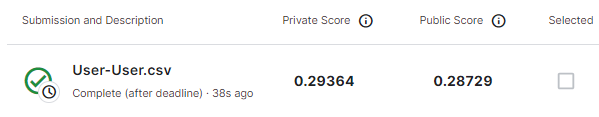

# Filtrado Colaborativo basado en Modelos

In [12]:
matriz_calificaciones = df_matriz.pivot(index='customer_id', columns='product_id', values='ranking')

In [13]:
matriz_calificaciones.replace(0, np.nan, inplace=True)


In [14]:
df_long = matriz_calificaciones.stack().reset_index()
df_long.columns = ['customer_id', 'product_id', 'ranking']


In [15]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_long[['customer_id', 'product_id', 'ranking']], reader)
#trainset, testset = train_test_split(data, test_size=0.01)


In [16]:
model = SVD()
#model.fit(trainset)
trainset = data.build_full_trainset()  # Utiliza todos los datos para el conjunto de entrenamiento
#predictions = model.test(testset)
model.fit(trainset)


In [17]:
""" rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")
 """

' rmse = accuracy.rmse(predictions)\nprint(f"RMSE: {rmse}")\n '

In [18]:
def get_unrated_products(df, user):
    rated_products = set(df[df['customer_id'] == user]['product_id'])
    all_products = set(df['product_id'].unique())
    unrated_products = all_products  # - rated_products
    return list(unrated_products)

all_predictions = []

for user in df_matriz['customer_id'].unique():
    unrated_products = get_unrated_products(df_matriz, user)
    for product in unrated_products:
        all_predictions.append((user, product, model.predict(user, product).est))


In [19]:
df_predictions = pd.DataFrame(all_predictions, columns=['customer_id', 'product_id', 'estimated_ranking'])
df_sorted = df_predictions.groupby('customer_id').apply(lambda x: x.nlargest(30, 'estimated_ranking')).reset_index(drop=True)


In [20]:
df_sorted 

,customer_id,product_id,estimated_ranking
0,1,456,5.000000
1,1,42,4.986929
2,1,414,4.907168
3,1,404,4.804179
4,1,426,4.772934
...,...,...,...
459355,15312,459,2.112784
459356,15312,406,2.096477
459357,15312,717,2.080579
459358,15312,206,2.073830


In [21]:
df_sorted.drop('estimated_ranking', axis=1, inplace=True)
df_recommendations = df_sorted.groupby('customer_id')['product_id'].agg(list).reset_index()

In [22]:
df_recommendations['product_id'] = df_recommendations['product_id'].apply(lambda x: ' '.join(map(str, x)))

df_recommendations.to_csv('modelo.csv', index=False)

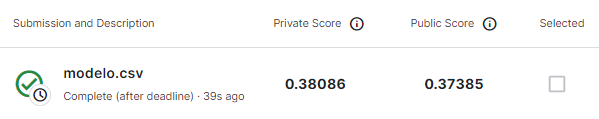

todo en dataset

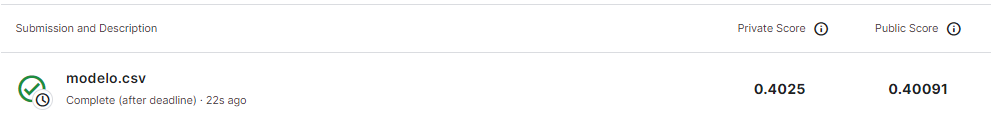

# Agrupamiento 

In [23]:
# Agrupar el DataFrame por la columna "type_id"
grouped = df_matriz.groupby("type_id")

In [24]:
grupo_GA = grouped.get_group("GA")
grupo_PA = grouped.get_group("PA")
grupo_BO = grouped.get_group("BO")

In [25]:
matriz_calificaciones_GA = grupo_GA.pivot(index='customer_id', columns='product_id', values='ranking')
matriz_calificaciones_PA = grupo_PA.pivot(index='customer_id', columns='product_id', values='ranking')
matriz_calificaciones_BO = grupo_BO.pivot(index='customer_id', columns='product_id', values='ranking')

In [26]:
matriz_calificaciones_GA.replace(0, np.nan, inplace=True)
matriz_calificaciones_PA.replace(0, np.nan, inplace=True)
matriz_calificaciones_BO.replace(0, np.nan, inplace=True)

In [27]:
df_long_GA = matriz_calificaciones_GA.stack().reset_index()
df_long_PA = matriz_calificaciones_PA.stack().reset_index()
df_long_BO = matriz_calificaciones_BO.stack().reset_index()

df_long_GA.columns = ['customer_id', 'product_id', 'ranking']
df_long_PA.columns = ['customer_id', 'product_id', 'ranking']
df_long_BO.columns = ['customer_id', 'product_id', 'ranking']

In [28]:
reader = Reader(rating_scale=(1, 5))

data_GA = Dataset.load_from_df(df_long_GA[['customer_id', 'product_id', 'ranking']], reader)
data_PA = Dataset.load_from_df(df_long_PA[['customer_id', 'product_id', 'ranking']], reader)
data_BO = Dataset.load_from_df(df_long_BO[['customer_id', 'product_id', 'ranking']], reader)

In [29]:
model_GA = SVD()
model_PA = SVD()
model_BO = SVD()

trainset_GA = data_GA.build_full_trainset()  # Utiliza todos los datos para el conjunto de entrenamiento
trainset_PA = data_PA.build_full_trainset()
trainset_BO = data_BO.build_full_trainset()

model_GA.fit(trainset)
model_PA.fit(trainset)
model_BO.fit(trainset)

In [30]:
def get_unrated_products(df, user):
    rated_products = set(df[df['customer_id'] == user]['product_id'])
    all_products = set(df['product_id'].unique())
    unrated_products = all_products  # - rated_products
    return list(unrated_products)

In [31]:
all_predictions_GA = []
for user in grupo_GA['customer_id'].unique():
    unrated_products = get_unrated_products(grupo_GA, user)
    for product in unrated_products:
        all_predictions_GA.append((user, product, model_GA.predict(user, product).est))

In [32]:
all_predictions_PA = []
for user in grupo_PA['customer_id'].unique():
    unrated_products = get_unrated_products(grupo_PA, user)
    for product in unrated_products:
        all_predictions_PA.append((user, product, model_PA.predict(user, product).est))

In [33]:
all_predictions_BO = []
for user in grupo_BO['customer_id'].unique():
    unrated_products = get_unrated_products(grupo_BO, user)
    for product in unrated_products:
        all_predictions_BO.append((user, product, model_BO.predict(user, product).est))

In [34]:
df_predictions_GA = pd.DataFrame(all_predictions_GA, columns=['customer_id', 'product_id', 'estimated_ranking'])
df_predictions_PA = pd.DataFrame(all_predictions_PA, columns=['customer_id', 'product_id', 'estimated_ranking'])
df_predictions_BO = pd.DataFrame(all_predictions_BO, columns=['customer_id', 'product_id', 'estimated_ranking'])


df_sorted_GA = df_predictions_GA.groupby('customer_id').apply(lambda x: x.nlargest(30, 'estimated_ranking')).reset_index(drop=True)
df_sorted_PA = df_predictions_PA.groupby('customer_id').apply(lambda x: x.nlargest(30, 'estimated_ranking')).reset_index(drop=True)
df_sorted_BO = df_predictions_BO.groupby('customer_id').apply(lambda x: x.nlargest(30, 'estimated_ranking')).reset_index(drop=True)

In [35]:
df_sorted_GA.drop('estimated_ranking', axis=1, inplace=True)
df_sorted_PA.drop('estimated_ranking', axis=1, inplace=True)
df_sorted_BO.drop('estimated_ranking', axis=1, inplace=True)

df_recommendations_GA = df_sorted_GA.groupby('customer_id')['product_id'].agg(list).reset_index()
df_recommendations_PA = df_sorted_PA.groupby('customer_id')['product_id'].agg(list).reset_index()
df_recommendations_BO = df_sorted_BO.groupby('customer_id')['product_id'].agg(list).reset_index()

In [36]:
# Unir los DataFrames
merged_df = pd.concat([df_recommendations_GA, df_recommendations_PA, df_recommendations_BO], ignore_index=True)

In [37]:
merged_df['product_id'] = merged_df['product_id'].apply(lambda x: ' '.join(map(str, x)))

merged_df.to_csv('modelo2.csv', index=False)

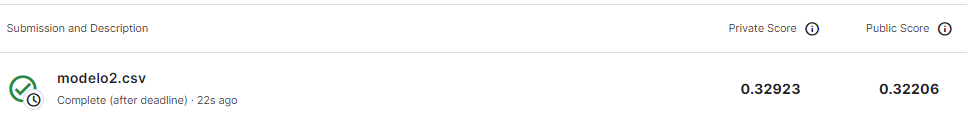

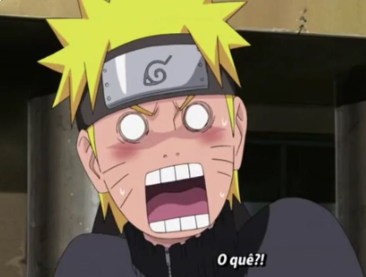

#  sistema de recomendación híbrido

In [7]:
df_com = df_ranking

In [10]:
df_com

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,ranking
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211,1
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,0
3,2022-01-31,9382,512,BO,21,V,1.0,0.153431,0.005211,1
4,2022-01-31,9382,525,BO,21,V,1.0,0.153431,0.005790,0
...,...,...,...,...,...,...,...,...,...,...
2167843,2023-02-04,646,667,PA,31,B,55.0,2085.986380,796.101767,5
2167844,2023-02-04,13758,667,PA,31,B,60.0,2339.780728,868.474655,3
2167845,2023-02-04,3111,673,GA,31,B,64.0,2460.348170,926.372966,5
2167846,2023-02-04,10520,679,PA,31,B,100.0,3531.912728,1447.457759,2


In [20]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy


In [13]:
columnas_deseadas = ['customer_id', 'product_id', 'ranking']
df_com = df_ranking[columnas_deseadas].copy()

In [14]:
df_com

,customer_id,product_id,ranking
0,7157,510,2
1,7157,512,1
2,9382,510,0
3,9382,512,1
4,9382,525,0
...,...,...,...
2167843,646,667,5
2167844,13758,667,3
2167845,3111,673,5
2167846,10520,679,2


In [17]:
# Eliminar filas duplicadas basadas en todas las columnas
df_com = df_com.drop_duplicates()

In [18]:
df_com

,customer_id,product_id,ranking
0,7157,510,2
1,7157,512,1
2,9382,510,0
3,9382,512,1
4,9382,525,0
...,...,...,...
2167755,14180,34,1
2167770,13903,679,1
2167810,8531,679,1
2167822,2693,679,1


In [34]:

# Define el formato del conjunto de datos (userID, itemID, rating)
reader = Reader(rating_scale=(1, 5))  # Ajusta el rango de puntuaciones si es necesario

# Cargar los datos en el formato adecuado para Surprise
data = Dataset.load_from_df(df_com[['customer_id', 'product_id', 'ranking']], reader=reader)

# Construir el conjunto de entrenamiento completo
trainset = data.build_full_trainset()

# Definir el algoritmo de recomendación (KNNBasic)
algo = KNNBasic()

# Entrenar el algoritmo en el conjunto de entrenamiento
algo.fit(trainset)

# Generar predicciones para todo el conjunto de datos
predictions = algo.test(trainset.build_testset())

# Evaluar el rendimiento del modelo en los datos de entrenamiento
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6486
MAE:  0.3439
RMSE: 0.6486
MAE: 0.3439


In [38]:
data = df_ranking

In [39]:
data

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,ranking
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211,1
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,0
3,2022-01-31,9382,512,BO,21,V,1.0,0.153431,0.005211,1
4,2022-01-31,9382,525,BO,21,V,1.0,0.153431,0.005790,0
...,...,...,...,...,...,...,...,...,...,...
2167843,2023-02-04,646,667,PA,31,B,55.0,2085.986380,796.101767,5
2167844,2023-02-04,13758,667,PA,31,B,60.0,2339.780728,868.474655,3
2167845,2023-02-04,3111,673,GA,31,B,64.0,2460.348170,926.372966,5
2167846,2023-02-04,10520,679,PA,31,B,100.0,3531.912728,1447.457759,2


In [45]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Carga tus datos en un DataFrame de pandas
# data = pd.read_csv('ruta_del_archivo.csv')

# Crear un DataFrame de características relevantes para el filtrado basado en vecinos
features_df = data[['product_id', 'type_id', 'business_id', 'channel_id', 'cantidad_venta', 'monto_venta_transf', 'peso_venta_transf']]

# Aplicar codificación one-hot a características categóricas
encoded_features = pd.get_dummies(features_df, columns=['type_id', 'business_id', 'channel_id'])

# Calcular la matriz de similitud coseno entre productos
similarity_matrix = cosine_similarity(encoded_features.drop('product_id', axis=1))

# Crear un modelo de vecinos cercanos
num_neighbors = 5  # Puedes ajustar este valor según tus necesidades
neighbors_model = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine')
neighbors_model.fit(similarity_matrix)

# Ejemplo: Obtén recomendaciones para un producto dado (index)
product_index = 0
product_features = encoded_features.iloc[product_index, 1:].values.reshape(1, -1)

# Encuentra los índices de los productos vecinos más cercanos
distances, neighbor_indices = neighbors_model.kneighbors(product_features)

# Recomienda los productos vecinos más cercanos
print("Recomendaciones para el producto:", data.loc[product_index, 'product_id'])
for idx in neighbor_indices.flatten():
    print(data.loc[idx, 'product_id'])


MemoryError: Unable to allocate 34.2 TiB for an array with shape (2167848, 2167848) and data type float64